# Day 25 - Using convolutions to generalize

* I spent a lot of time playing around with convolutional layers in the previous notebook

## Convolutions in action

* One interesting thing to look at is the size of the weight tensor of a kernel
* In general, the shape is `[n_out, n_in]`, so we can guess that it should be `[16, 3, 3, 3]`
* Here, it would represent $C'\times C\times H\times W$, where $C'$ is the number of output channels

In [1]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

conv = nn.Conv2d(3, 16, kernel_size=3)
list(conv.parameters())[0].shape

torch.Size([16, 3, 3, 3])

## Subclassing `nn.Module`

* As a simple, illustrative example, we will reimplement the `Flatten` layer as an `nn.Module` subclass

In [2]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [3]:
x = torch.ones(32, 3, 32, 32)
model = Flatten()
x = model(x)
x.shape

torch.Size([32, 3072])

### The `functional` API

* The `nn.functional` module provides stateless, true functions
* It is usually importes as `F`
* Using functions like `F.relu()` or `F.max_pool2d` means that they won't have to be registered as submodules to a Module subclass

## Training our convolution neural network

* While we did this in the previous notebook, let us reproduce it here in a slightly altered form to store the model for later

In [4]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision import transforms
import matplotlib.pyplot as plt

In [5]:
data_path = "./DLPT/data/"
mean = [0.4913996458053589, 0.48215845227241516, 0.44653093814849854]
std = [0.24703224003314972, 0.24348513782024384, 0.26158785820007324]

In [6]:
normalize = transforms.Normalize(mean, std)
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

cifar10 = datasets.CIFAR10(data_path, transform=transform)
cifar10_val = datasets.CIFAR10(data_path, train=False, transform=transform)
cifar10_images = datasets.CIFAR10(data_path, train=False)

In [7]:
class_names = ["airplane", "bird"]
label_map = {0: 0, 2: 1}
classes = torch.tensor([0, 2])

In [8]:
from torch.utils.data import TensorDataset

indices_train = torch.where(torch.isin(torch.tensor(cifar10.targets), classes))[0]
indices_val = torch.where(torch.isin(torch.tensor(cifar10_val.targets), classes))[0]

samples_train = torch.stack([cifar10[i][0] for i in indices_train])
samples_val = torch.stack([cifar10_val[i][0] for i in indices_val])

targets_train = torch.tensor([cifar10[i][1] == 2 for i in indices_train]).long()
targets_val = torch.tensor([cifar10_val[i][1] == 2 for i in indices_val]).long()

set_train = TensorDataset(samples_train, targets_train)
set_val = TensorDataset(samples_val, targets_val)

In [9]:
from torch.utils.data import DataLoader

batch_size = 384
loader_train = DataLoader(
    set_train,
    batch_size,
    shuffle=True,
    pin_memory=True,
)
loader_val = DataLoader(
    set_val,
    len(set_val),
    shuffle=False,
    pin_memory=True,
)

In [10]:
import numpy as np
from tqdm.auto import tqdm


def training_loop(n_epochs, optimizer, model, loss_fn, data_train, data_val, rep_freq=1000, path=None):
    train_losses = np.zeros(n_epochs)
    val_losses = np.zeros(n_epochs)
    val_accs = np.zeros(n_epochs)

    # Exponential weight factor
    alpha = 0.3
    best_acc = 0.0
    
    for epoch in tqdm(range(1, n_epochs + 1), desc="Epochs"):
        # Initialize batch averages for each epoch
        batch_losses_train = []
        batch_losses_val = []
        batch_accs = []
        
        # Training phase
        for batch_imgs, batch_targets in data_train:
            batch_imgs = batch_imgs.to(device=device, non_blocking=True)
            batch_targets = batch_targets.to(device=device, non_blocking=True)
            batch_out = model(batch_imgs)
            loss_train = loss_fn(batch_out, batch_targets)
            batch_losses_train.append(loss_train.item())
            
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
        # Validation phase
        with torch.no_grad():
            for val_imgs, val_targets in data_val:
                val_imgs = val_imgs.to(device=device, non_blocking=True)
                val_targets = val_targets.to(device=device, non_blocking=True)
                model.eval()
                val_out = model(val_imgs)
                loss_val = loss_fn(val_out, val_targets)
                batch_losses_val.append(loss_val.item())
                
                preds = val_out.argmax(dim=-1)
                targets = val_targets.to(device=device)
                total_correct = (targets == preds).sum()
                accuracy = total_correct / preds.shape[0]
                batch_accs.append(accuracy.item())
                model.train()
        
        # Calculate average metrics for this epoch
        epoch_train_loss = np.mean(batch_losses_train)
        epoch_val_loss = np.mean(batch_losses_val)
        epoch_val_acc = np.mean(batch_accs)
        
        # Store metrics with exponential weighting
        if epoch == 1:
            # First epoch: use raw values
            train_losses[epoch-1] = epoch_train_loss
            val_losses[epoch-1] = epoch_val_loss
            val_accs[epoch-1] = epoch_val_acc
        else:
            # Subsequent epochs: use exponential weighted average
            train_losses[epoch-1] = (1 - alpha) * train_losses[epoch-2] + alpha * epoch_train_loss
            val_losses[epoch-1] = (1 - alpha) * val_losses[epoch-2] + alpha * epoch_val_loss
            val_accs[epoch-1] = (1 - alpha) * val_accs[epoch-2] + alpha * epoch_val_acc

        if epoch == 1 or epoch == n_epochs or epoch % rep_freq == 0:
            print(f"Epoch {epoch}, Training loss {train_losses[epoch-1]:.4f},"
                  f" Validation loss {val_losses[epoch-1]:.4f},"
                  f" Validation accuracy: {val_accs[epoch-1] * 100:.2f}%")
            if path and epoch_val_acc > best_acc:
                print("New best accuracy!")
                best_acc = epoch_val_acc
                torch.save(model.state_dict(), path)

    return train_losses, val_losses, val_accs

In [11]:
from torch import optim, nn
import torch.nn.functional as F


class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        out_channels: int = 32,
        kernel_size: int = 3,
        padding: int = 1,
        dropout: float = 0.5,
    ):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            padding=padding,
        )
        
        self.dropout = dropout

    def forward(self, x):
        out = self.conv(x)
        out = F.dropout2d(out, self.dropout, self.training)
        out = F.relu(out)
        return F.max_pool2d(out, 2, 2)


class ClassifierHead(nn.Module):
    def __init__(self, in_features, out_features, n_classes, dropout):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.classifier = nn.Linear(out_features, n_classes)
        
        self.dropout = dropout

    def forward(self, x):
        out = x.flatten(1)
        out = self.linear(out)
        out = F.dropout(out, self.dropout, self.training)
        out = F.relu(out)
        return self.classifier(out)


class Superman(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.convs = nn.Sequential(
            ConvBlock(3, 32, dropout=0.2),
            ConvBlock(32, 64, dropout=0.5),
            ConvBlock(64, 128, dropout=0.5),
        )
        self.head = ClassifierHead(2048, 512, n_classes, 0.5)

    def forward(self, x):
        out = self.convs(x)
        return self.head(out)

In [12]:
torch.set_float32_matmul_precision('high')

n_classes = 2
model = torch.compile(Superman(n_classes).to(device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

In [13]:
models_path = "./DLPT/models/"
model_name = "superman"
tl, vl, va = training_loop(
    n_epochs = 4_000,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    data_train = loader_train,
    data_val = loader_val,
    rep_freq=100,
    path = models_path + model_name + ".pt"
)

Epochs:   0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 1, Training loss 0.5943, Validation loss 0.4806, Validation accuracy: 77.80%
New best accuracy!
Epoch 100, Training loss 0.1767, Validation loss 0.1811, Validation accuracy: 92.70%
New best accuracy!
Epoch 200, Training loss 0.1358, Validation loss 0.1746, Validation accuracy: 93.14%
New best accuracy!
Epoch 300, Training loss 0.1269, Validation loss 0.1688, Validation accuracy: 93.30%
Epoch 400, Training loss 0.1155, Validation loss 0.1823, Validation accuracy: 93.10%
Epoch 500, Training loss 0.1107, Validation loss 0.1681, Validation accuracy: 93.33%
Epoch 600, Training loss 0.1131, Validation loss 0.1763, Validation accuracy: 93.27%
New best accuracy!
Epoch 700, Training loss 0.1036, Validation loss 0.1710, Validation accuracy: 93.56%
Epoch 800, Training loss 0.0962, Validation loss 0.1758, Validation accuracy: 93.19%
Epoch 900, Training loss 0.1008, Validation loss 0.1670, Validation accuracy: 93.68%
New best accuracy!
Epoch 1000, Training loss 0.1196, Validation loss 0.1723,

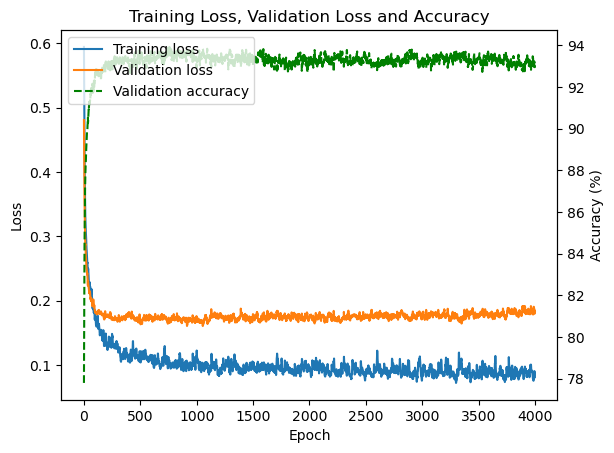

In [14]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(tl, label="Training loss")
ax1.plot(vl, label="Validation loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2 = ax1.twinx()

color = "tab:green"
ax2.plot(va * 100, 'g--', label="Validation accuracy")
ax2.set_ylabel("Accuracy (%)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Training Loss, Validation Loss and Accuracy")
plt.show()

In [15]:
model = torch.compile(Superman(n_classes).to(device=device))
model.load_state_dict(torch.load(models_path + model_name + ".pt",
                                 weights_only=True,
                                 map_location=device
                                ))

<All keys matched successfully>

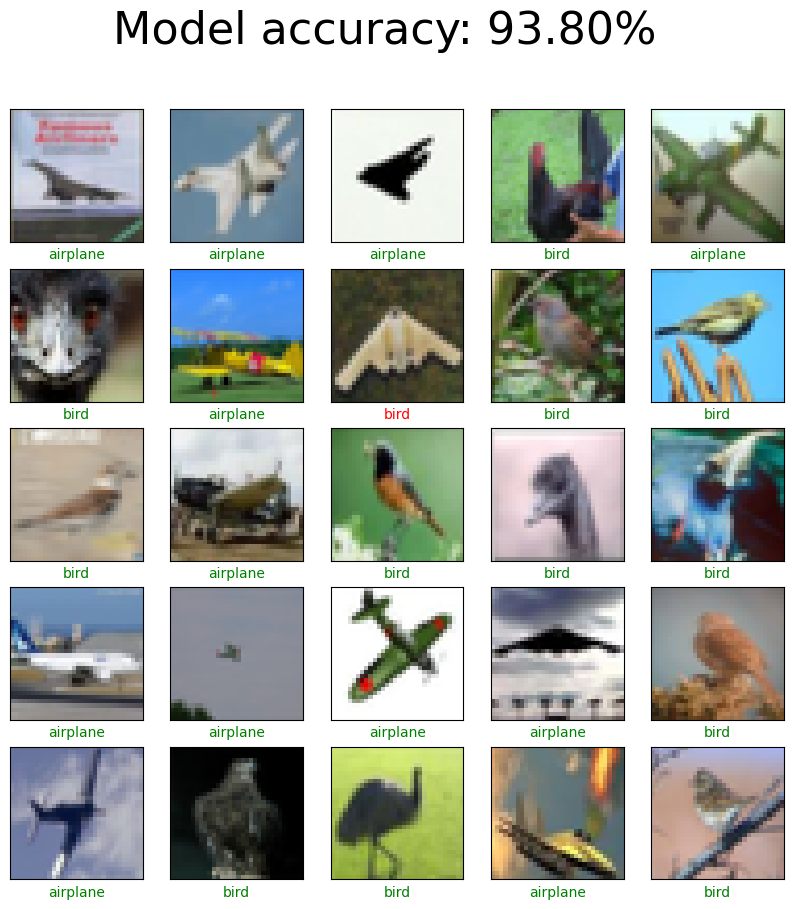

In [16]:
with torch.no_grad():
    model.eval()
    for samples, targets in loader_val:
        preds = model(samples.to(device=device)).argmax(dim=-1)
        targets = targets.to(device=device)

cifar2_val_imgs = [img
                   for img, label in cifar10_images
                   if label in [0, 2]]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
total_correct = (targets == preds).sum()
accuracy = total_correct / preds.shape[0]
fig.suptitle(f"Model accuracy: {accuracy * 100:.2f}%", fontsize=32)

for i in range(25):
    r = i // 5
    c = i % 5
    img = cifar2_val_imgs[i]
    axes[r, c].imshow(img)
    correct = (preds[i] == targets[i]).item()
    color = "green" if correct else "red"
    axes[r, c].set_xlabel(class_names[preds[i]], color=color)
    
    axes[r, c].set_xticks([])
    axes[r, c].set_yticks([])

plt.show()

## Model design

### Going deeper to learn more complex structures: Depth

* Let us see how we can build a ResNet in PyTorch

In [17]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super().__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity="relu")
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(x)
        out = torch.relu(out)
        return out + x

In [18]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=100):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *[ResBlock(n_chans=n_chans1) for _ in range(n_blocks)])
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        return self.fc2(out)

In [19]:
depth=10
model = torch.compile(NetResDeep(n_blocks=depth).to(device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

In [20]:
model_name = "net_res_deep_superman"
tl, vl, va = training_loop(
    n_epochs = 20_000,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    data_train = loader_train,
    data_val = loader_val,
    rep_freq=100,
    path = models_path + model_name + ".pt"
)

Epochs:   0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1, Training loss 0.5782, Validation loss 0.4583, Validation accuracy: 79.75%
New best accuracy!
Epoch 100, Training loss 0.0067, Validation loss 0.5782, Validation accuracy: 88.52%
New best accuracy!
Epoch 200, Training loss 0.0132, Validation loss 0.5841, Validation accuracy: 88.14%
Epoch 300, Training loss 0.0099, Validation loss 0.6768, Validation accuracy: 88.00%
Epoch 400, Training loss 0.0013, Validation loss 0.6259, Validation accuracy: 88.80%
New best accuracy!
Epoch 500, Training loss 0.0015, Validation loss 0.6256, Validation accuracy: 89.19%
New best accuracy!
Epoch 600, Training loss 0.0323, Validation loss 0.6391, Validation accuracy: 88.27%
Epoch 700, Training loss 0.0071, Validation loss 0.6338, Validation accuracy: 88.34%
Epoch 800, Training loss 0.0015, Validation loss 0.6138, Validation accuracy: 89.46%
New best accuracy!
Epoch 900, Training loss 0.0021, Validation loss 0.5772, Validation accuracy: 89.15%
Epoch 1000, Training loss 0.0016, Validation loss 0.6186,

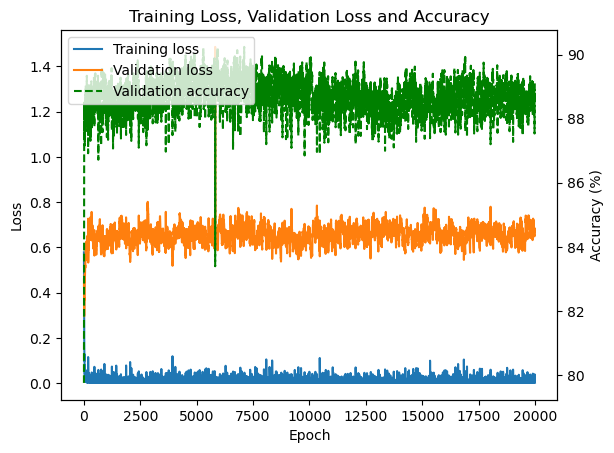

In [21]:
fig, ax1 = plt.subplots()

ax1.plot(tl, label="Training loss")
ax1.plot(vl, label="Validation loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2 = ax1.twinx()

color = "tab:green"
ax2.plot(va * 100, 'g--', label="Validation accuracy")
ax2.set_ylabel("Accuracy (%)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title("Training Loss, Validation Loss and Accuracy")
plt.show()

In [22]:
model = torch.compile(NetResDeep(n_blocks=depth).to(device=device))
model.load_state_dict(torch.load(models_path + model_name + ".pt",
                                 weights_only=True,
                                 map_location=device
                                ))

<All keys matched successfully>

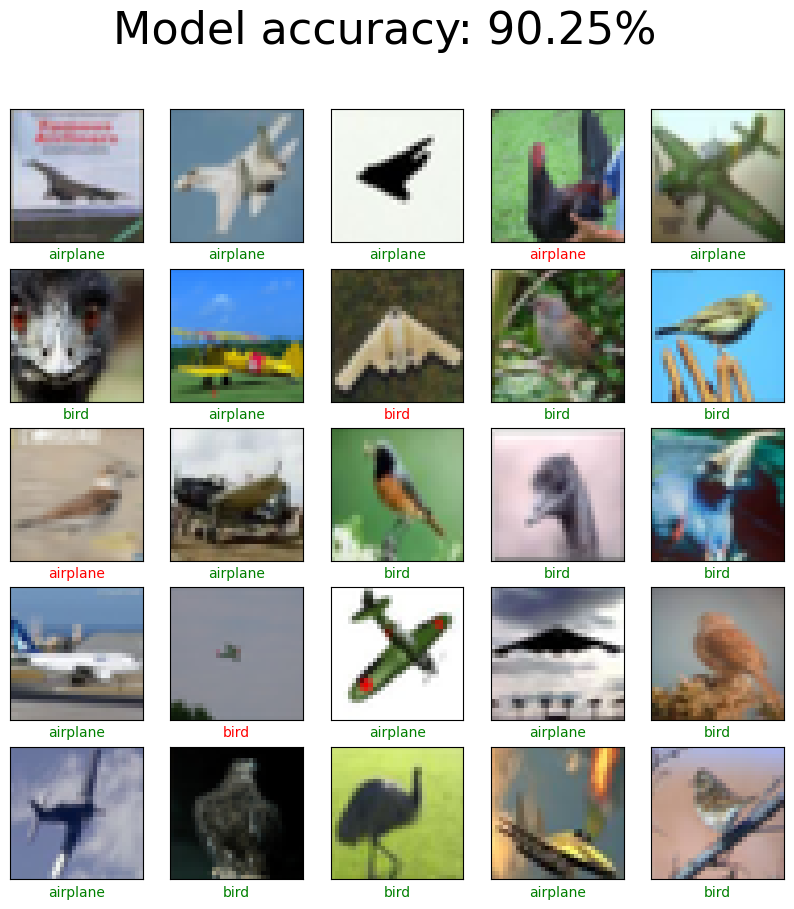

In [23]:
with torch.no_grad():
    model.eval()
    for samples, targets in loader_val:
        preds = model(samples.to(device=device)).argmax(dim=-1)
        targets = targets.to(device=device)

cifar2_val_imgs = [img
                   for img, label in cifar10_images
                   if label in [0, 2]]

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
total_correct = (targets == preds).sum()
accuracy = total_correct / preds.shape[0]
fig.suptitle(f"Model accuracy: {accuracy * 100:.2f}%", fontsize=32)

for i in range(25):
    r = i // 5
    c = i % 5
    img = cifar2_val_imgs[i]
    axes[r, c].imshow(img)
    correct = (preds[i] == targets[i]).item()
    color = "green" if correct else "red"
    axes[r, c].set_xlabel(class_names[preds[i]], color=color)
    
    axes[r, c].set_xticks([])
    axes[r, c].set_yticks([])

plt.show()